## Getting data on salaries and checking basic descriptive statistics

In [1]:
import pandas as pd
url = "https://vincentarelbundock.github.io/Rdatasets/csv/carData/Salaries.csv"
data = pd.read_csv(url)
print(data.head())
data.info()
print(data.shape)
print(data.isnull().sum())
print(data.describe())
print(list(data.columns))

   rownames      rank discipline  yrs.since.phd  yrs.service   sex  salary
0         1      Prof          B             19           18  Male  139750
1         2      Prof          B             20           16  Male  173200
2         3  AsstProf          B              4            3  Male   79750
3         4      Prof          B             45           39  Male  115000
4         5      Prof          B             40           41  Male  141500
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rownames       397 non-null    int64 
 1   rank           397 non-null    object
 2   discipline     397 non-null    object
 3   yrs.since.phd  397 non-null    int64 
 4   yrs.service    397 non-null    int64 
 5   sex            397 non-null    object
 6   salary         397 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 21.8+ KB
(397, 7)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Exploring the data

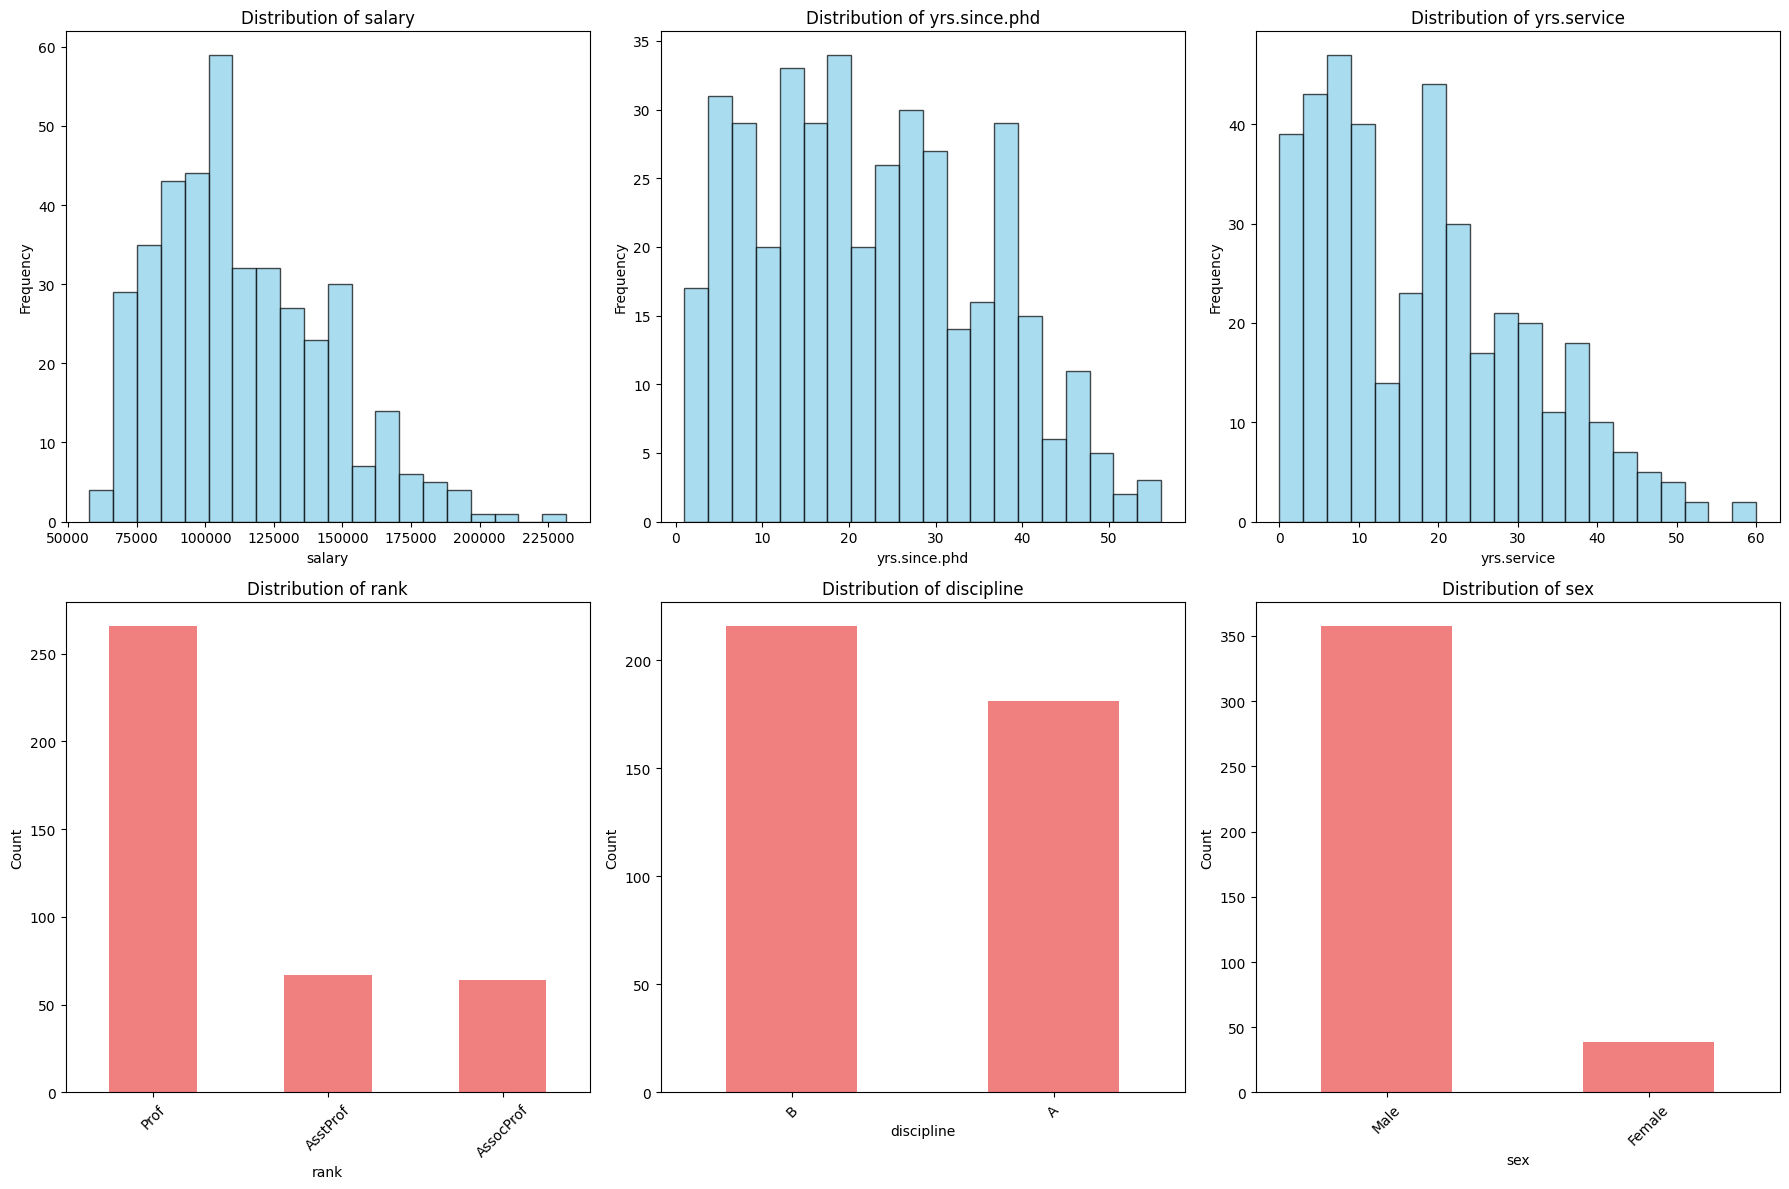

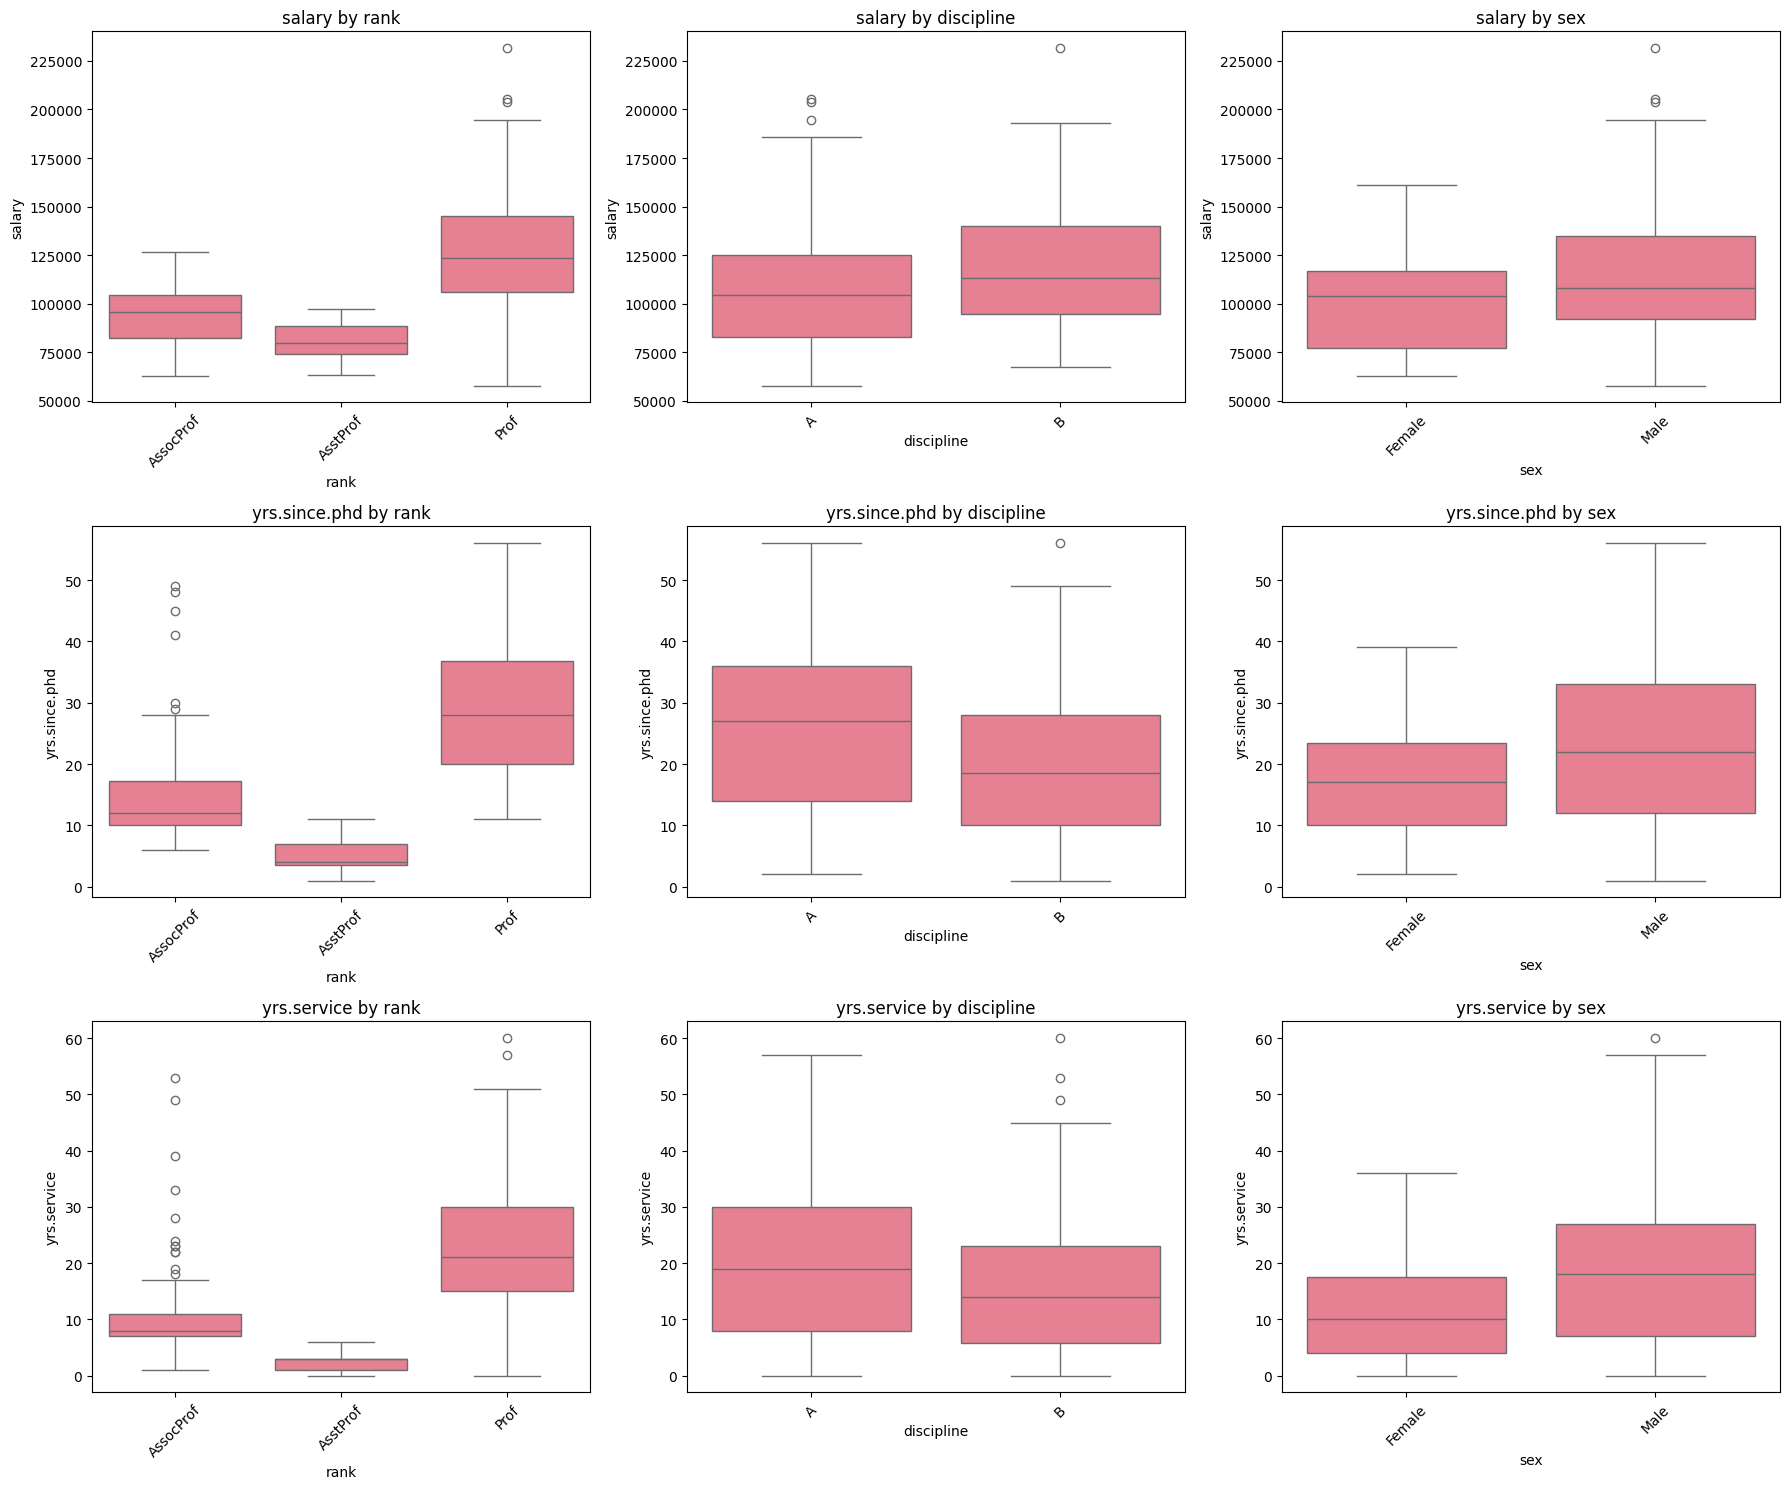

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # distribution plots for dependent variables
dependent_vars = ['salary', 'yrs.since.phd', 'yrs.service']
for i, var in enumerate(dependent_vars):
    axes[0, i].hist(data[var], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, i].set_title(f'Distribution of {var}')
    axes[0, i].set_xlabel(var)
    axes[0, i].set_ylabel('Frequency') # bar plots for categorical variables
categorical_vars = ['rank', 'discipline', 'sex']
for i, var in enumerate(categorical_vars):
    data[var].value_counts().plot(kind='bar', ax=axes[1, i], color='lightcoral')
    axes[1, i].set_title(f'Distribution of {var}')
    axes[1, i].set_xlabel(var)
    axes[1, i].set_ylabel('Count')
    axes[1, i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show() # box plots to show relationships between categorical and continuous variables
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

for i, dep_var in enumerate(dependent_vars):
    for j, cat_var in enumerate(categorical_vars):
        sns.boxplot(data=data, x=cat_var, y=dep_var, ax=axes[i, j])
        axes[i, j].set_title(f'{dep_var} by {cat_var}')
        axes[i, j].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show() # lots of plots! some outliers, especially for yars.since.phd and yrs.service for associate professors

                 salary  yrs.since.phd  yrs.service
salary         1.000000       0.419231     0.334745
yrs.since.phd  0.419231       1.000000     0.909649
yrs.service    0.334745       0.909649     1.000000


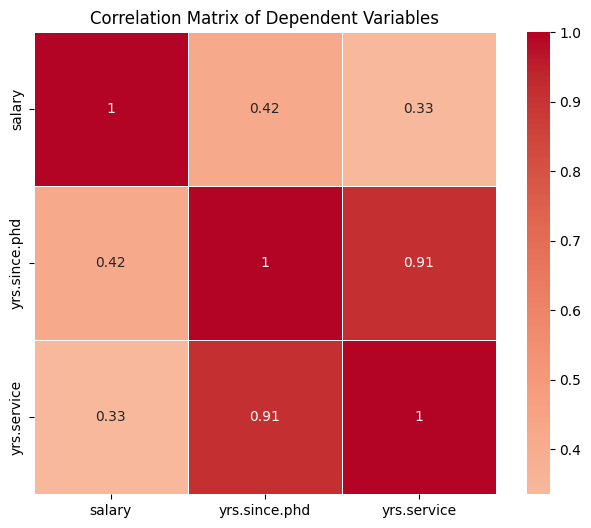

In [4]:
continuous_vars = ['salary', 'yrs.since.phd', 'yrs.service']
corr_matrix = data[continuous_vars].corr()
print(corr_matrix) # correlation matrix as seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Dependent Variables')
plt.show() # of course, years.since.phd and yrs.service are highly correlated

## Preparing the data

In [5]:
print("Current data types:")
print(data.dtypes)
for var in ['rank', 'discipline', 'sex']: # ensure categorical variables are properly formatted
    print(f"{var}: {data[var].unique()}")
categorical_columns = ['rank', 'discipline', 'sex'] # convert categorical variables to categorical type
for col in categorical_columns:
    data[col] = data[col].astype('category')
print("--------------------------------------------------------------")
print(data[categorical_columns].dtypes)

Current data types:
rownames          int64
rank             object
discipline       object
yrs.since.phd     int64
yrs.service       int64
sex              object
salary            int64
dtype: object
rank: ['Prof' 'AsstProf' 'AssocProf']
discipline: ['B' 'A']
sex: ['Male' 'Female']
--------------------------------------------------------------
rank          category
discipline    category
sex           category
dtype: object


## Checking assumptions for MANOVA

In [28]:
dependent_vars = ['salary', 'yrs.since.phd', 'yrs.service']
for var in dependent_vars:
    stat, p_value = stats.shapiro(data[var])
    print(f"{var}: statistic = {stat:.4f}, p-value = {p_value:.6f}")
print("--------------------------------------------------------------")
for var in dependent_vars:
    groups_data = [data[data['rank'] == group][var] for group in data['rank'].unique()] #creates a list of arrays: [AsstProf_salaries, AssocProf_salaries, Prof_salaries]
    statistic, p_value = stats.levene(*groups_data) # * unpacks the list
    print(f"{var}: Levene statistic = {statistic:.4f}, p-value = {p_value:.6f}")
print("--------------------------------------------------------------")
for var in dependent_vars:
    z_scores = np.abs(stats.zscore(data[var]))
    outliers = np.sum(z_scores > 3)
    print(f"{var}: {outliers} potential outliers")
    for i in range(len(z_scores)):
        if z_scores[i] > 3:
            print(f"  Outlier value: {data[var].iloc[i]} at index {i}, z-score: {z_scores[i]}") # these outliers are acceptable, maybe the 3.89 is the dean?

salary: statistic = 0.9599, p-value = 0.000000
yrs.since.phd: statistic = 0.9696, p-value = 0.000000
yrs.service: statistic = 0.9418, p-value = 0.000000
--------------------------------------------------------------
salary: Levene statistic = 38.7111, p-value = 0.000000
yrs.since.phd: Levene statistic = 35.1601, p-value = 0.000000
yrs.service: Levene statistic = 39.4723, p-value = 0.000000
--------------------------------------------------------------
salary: 2 potential outliers
  Outlier value: 231545 at index 43, z-score: 3.8953773005457175
  Outlier value: 205500 at index 364, z-score: 3.034410248101501
yrs.since.phd: 0 potential outliers
yrs.service: 2 potential outliers
  Outlier value: 57 at index 131, z-score: 3.0320633540256257
  Outlier value: 60 at index 330, z-score: 3.263016759925122


### MANOVA

In [36]:
# Independent variables: rank, discipline, sex ; Dependent variables: salary, yrs.since.phd, yrs.service
formula = 'salary + Q("yrs.since.phd") + Q("yrs.service") ~ C(rank) + C(discipline) + C(sex) + C(rank):C(discipline) + C(rank):C(sex) + C(discipline):C(sex)'
manova = MANOVA.from_formula(formula, data=data) # we purposefully avoid the 3-way interaction, because some subgroups can have too few observations or even be empty
manova_results = manova.mv_test() #I also ran the MANOVA 3 more times, each time cutting an interaction, but sex never was significant, the closest it came to was when I cut rank:sex
print(manova_results) # rank and discipline are highly significant

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8049 3.0000 385.0000 31.1088 0.0000
         Pillai's trace 0.1951 3.0000 385.0000 31.1088 0.0000
 Hotelling-Lawley trace 0.2424 3.0000 385.0000 31.1088 0.0000
    Roy's greatest root 0.2424 3.0000 385.0000 31.1088 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        C(rank)         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8768 6.0000 770.0000  8.7232 0.0000
         Pillai's trace 0.1241 6.0000 772.0000  8.5143 0.0000
 Hotelling-Lawley trace 0.

### Post-hoc analysis; pairwise comparisons

In [40]:
from scipy.stats import ttest_ind
ranks = data['rank'].unique() # for rank (most important from MANOVA)
for var in dependent_vars:
    print(f"\n{var.upper()} by RANK:")
    for i in range(len(ranks)):
        for j in range(i+1, len(ranks)):
            group1 = data[data['rank'] == ranks[i]][var]
            group2 = data[data['rank'] == ranks[j]][var]
            t_stat, p_val = ttest_ind(group1, group2)
            print(f"  {ranks[i]} vs {ranks[j]}: p = {p_val:.4f}")
disciplines = data['discipline'].unique() # for discipline (second most important from MANOVA)
for var in dependent_vars:
    print(f"\n{var.upper()} by DISCIPLINE:")
    for i in range(len(disciplines)):
        for j in range(i+1, len(disciplines)):
            group1 = data[data['discipline'] == disciplines[i]][var]
            group2 = data[data['discipline'] == disciplines[j]][var]
            t_stat, p_val = ttest_ind(group1, group2)
            print(f"  {disciplines[i]} vs {disciplines[j]}: p = {p_val:.4f}") # not much intel here, both are significant across all slices


SALARY by RANK:
  Prof vs AsstProf: p = 0.0000
  Prof vs AssocProf: p = 0.0000
  AsstProf vs AssocProf: p = 0.0000

YRS.SINCE.PHD by RANK:
  Prof vs AsstProf: p = 0.0000
  Prof vs AssocProf: p = 0.0000
  AsstProf vs AssocProf: p = 0.0000

YRS.SERVICE by RANK:
  Prof vs AsstProf: p = 0.0000
  Prof vs AssocProf: p = 0.0000
  AsstProf vs AssocProf: p = 0.0000

SALARY by DISCIPLINE:
  B vs A: p = 0.0018

YRS.SINCE.PHD by DISCIPLINE:
  B vs A: p = 0.0000

YRS.SERVICE by DISCIPLINE:
  B vs A: p = 0.0010


=== INTERACTION PLOTS ===


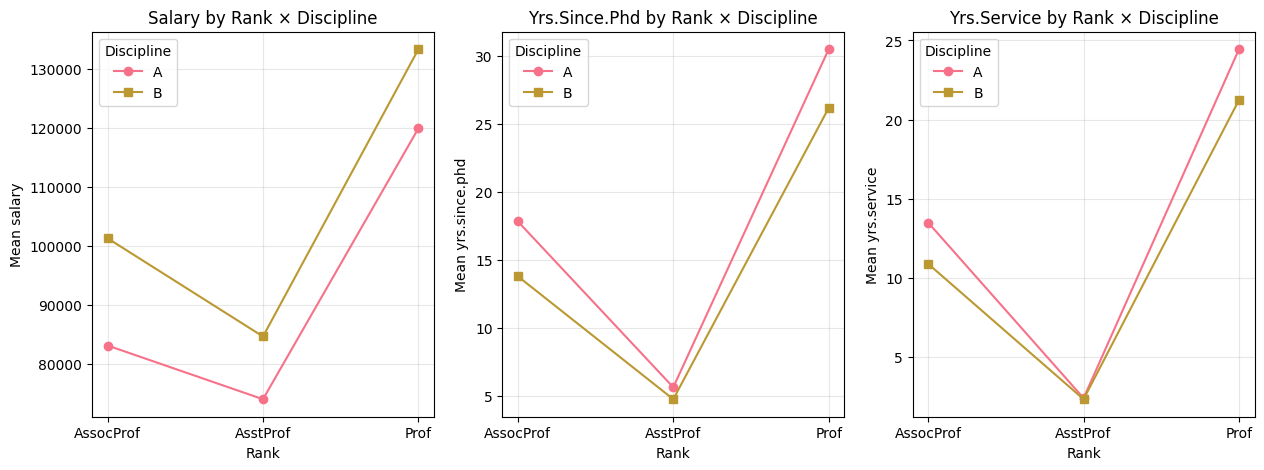

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, dep_var in enumerate(dependent_vars): # interaction plot: rank × discipline
    interaction_data = data.groupby(['rank', 'discipline'])[dep_var].mean().unstack()
    axes[i].plot(interaction_data.index, interaction_data.iloc[:, 0], marker='o', label=interaction_data.columns[0])
    axes[i].plot(interaction_data.index, interaction_data.iloc[:, 1], marker='s', label=interaction_data.columns[1])
    axes[i].set_title(f'{dep_var.title()} by Rank × Discipline')
    axes[i].set_xlabel('Rank')
    axes[i].set_ylabel(f'Mean {dep_var}')
    axes[i].legend(title='Discipline')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()